In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import os 
from random import shuffle
import cv2

TEST_DIR = 'test'
TRAIN_DIR = 'train'
LEARNING_RATE = 1e-3
MODEL_NAME = "dogsvscats-{}-{}.model".format(LEARNING_RATE,"6conv-fire")
IMAGE_SIZE = 100

In [2]:
def label_image(img):
    img_name = img.split(".")[-3]
    if img_name == "cat":
        return [1,0]
    elif img_name == "dog":
        return [0,1]

In [3]:
def train_data_loder():
    training_data = []
    for img in tqdm(os.listdir(path=TRAIN_DIR)):
        img_lable = label_image(img)
        path_to_img = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path_to_img,cv2.IMREAD_GRAYSCALE),(IMAGE_SIZE,IMAGE_SIZE))
        training_data.append([np.array(img),np.array(img_lable)])
        
    shuffle(training_data)
    np.save("training_data_new.npy",training_data)
    return training_data

In [4]:
def testing_data():
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        img_labels = img.split(".")[0]
        path_to_img = os.path.join(TEST_DIR,img)
        img = cv2.resize(cv2.imread(path_to_img,cv2.IMREAD_GRAYSCALE),(IMAGE_SIZE,IMAGE_SIZE))
        test_data.append([np.array(img),np.array(img_labels)])
        
    shuffle(test_data)
    np.save("test_dataone.npy",test_data)
    return test_data

In [5]:
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

convnet = input_data(shape=[None, IMAGE_SIZE, IMAGE_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LEARNING_RATE, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
if os.path.exists("{}.meta".format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print("Model Loaded")

INFO:tensorflow:Restoring parameters from /home/tankist/_Oxana/DS_6/Lab_work/LW9/dogsvscats-0.001-6conv-fire.model
Model Loaded


In [8]:
train = train_data_loder()[:-500]
test = train_data_loder()[-500:]

100%|██████████| 25000/25000 [00:26<00:00, 942.61it/s] 
/home/tankist/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
100%|██████████| 25000/25000 [00:13<00:00, 1787.44it/s]


In [9]:
# Це навчальні дані
X = np.array([i[0] for i in train]).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)
Y = [i[1] for i in train]

# Це тестові дані
test_x = np.array([i[0] for i in test]).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)
test_y = [i[1] for i in test]

In [10]:
model.fit(X, Y, n_epoch=6, validation_set=(test_x,  test_y), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 9191  | total loss: 0.06737 | time: 33.875s
| Adam | epoch: 006 | loss: 0.06737 - acc: 0.9824 -- iter: 24448/24500
Training Step: 9192  | total loss: 0.06401 | time: 34.963s
| Adam | epoch: 006 | loss: 0.06401 - acc: 0.9826 | val_loss: 0.08546 - val_acc: 0.9640 -- iter: 24500/24500
--


In [11]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/tankist/_Oxana/DS_6/Lab_work/LW9/dogsvscats-0.001-6conv-fire.model is not in all_model_checkpoint_paths. Manually adding it.


In [12]:
test_data = testing_data()

100%|██████████| 12500/12500 [00:13<00:00, 946.05it/s] 


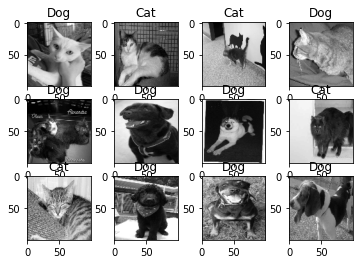

In [13]:
import matplotlib.pyplot as plt

figs = plt.figure()
for num,data in enumerate(test_data[:12]):
    test_img = data[0]
    test_lable = data[1]
    test_img_feed = test_img.reshape(IMAGE_SIZE,IMAGE_SIZE,1)
    t = figs.add_subplot(3,4,num+1)
    ores = test_img
    model_pred = model.predict([test_img_feed])[0]
    if np.argmax(model_pred) == 1:
        pred_val = "Dog"
    else:
        pred_val = "Cat"
        
    t.imshow(ores,cmap="gray")
    plt.title(pred_val)

In [14]:
with open("final_results(dogs).csv",mode="w") as f:
    f.write("id,pred \n")
    
with open("final_results.csv(dogs)",mode="a") as r:
    for data in tqdm(test_data):
        img_class = data[1]
        img = data[0]
        imgs = img.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
        model_out = model.predict([imgs])[0]
        r.write("{},{} \n".format(img_class,model_out[1]))

100%|██████████| 12500/12500 [00:11<00:00, 1058.18it/s]
